In [2]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from vector_quantize_pytorch import VectorQuantize
import os
from data.neural_field_datasets_shapenet import ShapeNetDataset, FlattenTransform3D, TokenTransform3D, ModelTransform3DFromTokens, ModelTransform3D
from training import training_nano_gpt
from utils.visualization3d import visualize_model3d, model_to_mesh
from vector_quantize_pytorch import ResidualVQ
from utils import get_default_device

from networks.nano_gpt import GPTConfig, GPT

torch.cuda.is_available()

/home/luca/.cache/pypoetry/virtualenvs/adl4cv-OvNqwVNf-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/luca/.cache/pypoetry/virtualenvs/adl4cv-OvNqwVNf-py3.10/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/luca/.cache/pypoetry/virtualenvs/adl4cv-OvNqwVNf-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints

True

In [4]:
import wandb
wandb.login()

True

In [5]:
rq_dict = torch.load("./models/rq_search_results/shapenet_retrained_learnable_rq_model_dim_1_vocab_127_batch_size_16_threshold_ema_dead_code_0_kmean_iters_1_num_quantizers_1_use_init_False.pth")
rq_dict.keys()

state_dict = rq_dict["state_dict"]
rq_config = rq_dict["rq_config"]

rvq = ResidualVQ(**rq_config)
rvq.load_state_dict(state_dict)
rvq.to(get_default_device())

token_transform = TokenTransform3D(rvq)
dataset = ShapeNetDataset(os.path.join("./", "datasets", "shapenet_nef_2", "pretrained"))

model_transform = ModelTransform3D(dataset[0][0]["model_config"])

dataset_model = ShapeNetDataset(os.path.join("./", "datasets", "shapenet_nef_2", "pretrained"), transform=model_transform)
dataset_token = ShapeNetDataset(os.path.join("./", "datasets", "shapenet_nef_2", "pretrained"), transform=token_transform)

In [7]:
# Config Training
config = training_nano_gpt.Config()
config.learning_rate=2e-3
config.eval_interval = 25
config.max_iters = 10000
config.weight_decay=0.05
config.decay_lr=True
config.lr_decay_iters=config.max_iters
config.warmup_iters=0.08*config.max_iters
config.batch_size = 2
config.gradient_accumulation_steps = 16
config.init_from = "resume"
config.out_dir ="models/scratch"
config.detailed_folder = "training_sample_5"
config.eval_iters = 4


config.wandb_project = "shapenet_token_transformer"
config.metric_interval = 250

cb_size = rvq.layers[0].codebook_size

# BIG: model_config = GPTConfig(n_embd=512, block_size=dataset_token[0][0].size(0), n_head=16, n_layer=8, vocab_size=cb_size + 1, dropout=0.0, max_len= None)
# SMALL: model_config = GPTConfig(n_embd=256, block_size=dataset_token[0][0].size(0), n_head=16, n_layer=6, vocab_size=cb_size + 1, dropout=0.0, max_len= None)
# MEDIUM:
model_config = GPTConfig(n_embd=384, block_size=dataset_token[0][0].size(0), n_head=16, n_layer=7, vocab_size=cb_size + 1, dropout=0.0, max_len= None)

In [8]:
token_dict = {
    "SOS": cb_size,
}


In [9]:
train_ratio = 0.9

def create_split_indices(n, train_ratio=0.9):
    # Generate a random permutation of indices from 0 to n-1
    shuffled_indices = torch.randperm(n)
    # Determine the cut-off for training data
    train_size = int(train_ratio * n)
    # Split indices into training and validation sets
    train_indices = shuffled_indices[:train_size]
    val_indices = shuffled_indices[train_size:]
    return train_indices, val_indices

train_indices, val_indices = create_split_indices(len(dataset))

def get_batch_lambda(config, dataset, model_config, split, losses = None):
    batch_size = config.batch_size
    
    if losses is not None:
        assert losses.shape[0] == len(dataset)
        training_losses = losses[:int(train_ratio * len(dataset))]
        val_losses = losses[int(train_ratio * len(dataset)):]

    # Select indices based on the split
    if split == 'train':
        # Randomly select batch_size indices from the train_indices
        # indices = train_indices[torch.randint(0, len(train_indices), (batch_size,))]
        if losses is not None:
            probabilities = torch.softmax(training_losses, dim=0)
            sampled_indices = torch.multinomial(probabilities, batch_size, replacement=True)
            indices = train_indices[sampled_indices.to(train_indices)]
        else:
            indices = train_indices[torch.randint(0, len(train_indices), (batch_size,))]
        
    elif split == 'val':
        if losses is not None:
            probabilities = torch.softmax(val_losses, dim=0)
            sampled_indices = torch.multinomial(probabilities, batch_size, replacement=True)
            indices = val_indices[sampled_indices.to(val_indices)]
        # Randomly select batch_size indices from the val_indices
        indices = val_indices[torch.randint(0, len(val_indices), (batch_size,))]
    
    
    # Initialize lists to hold the sequences and labels
    samples = []
    labels = []

    # Collect samples and labels
    for idx in indices:
        sample, label = dataset[idx]
        start_tokens = torch.Tensor([token_dict["SOS"]]).long()  # Start of sequence token
        sample = torch.cat((start_tokens.to(sample), sample.squeeze(-1)), dim=0)
        #start_tokens = torch.Tensor([0]).long()  # Start of sequence token
        #sample = torch.cat((start_tokens, sample + 1), dim=0)
        samples.append(sample)
        labels.append(label)

    # Prepare the sequences for model input
    max_len = dataset_token[0][0].size(0) + 1 #samples[0].size(0)
    x = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    y = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    
    for i, sample in enumerate(samples):
        end_index = sample.size(0) - 1
        x[i, :end_index] = sample[:-1]  # Exclude the last token for x
        y[i, :end_index] = sample[1:]   # Exclude the first token for y

    idx = torch.zeros((batch_size,), dtype=torch.long)
    x_cutted = torch.zeros((batch_size, model_config.block_size), dtype=torch.long)
    y_cutted = torch.zeros((batch_size, model_config.block_size), dtype=torch.long)

    for i, offset in enumerate(idx):
        x_cutted[i, :] = x[i, offset:offset + model_config.block_size]
        y_cutted[i, :] = y[i, offset:offset + model_config.block_size]

    # x and y have to be
    x_cutted = x_cutted.to(config.device)
    y_cutted = y_cutted.to(config.device)
    
    if losses is not None:
        return x_cutted, y_cutted, idx, indices

    return x_cutted, y_cutted, idx

create_get_batch = lambda config, dataset, model_config: lambda split, losses = None: get_batch_lambda(config, dataset, model_config, split, losses=losses)
get_batch = create_get_batch(config, dataset_token, model_config)

In [10]:
import wandb

def custom_eval(pred: torch.Tensor, mode: str, k: int, x, y, loss=None):
  if mode == "val":
    return

  if k != 1:
    return

  tokens_batch = pred.detach().argmax(dim=-1)

  orig_objs = []
  objs = []
  losses = {}

  for i in range(2):

    tokens_orig = y[i]
    model_dict = token_transform.inverse(tokens_orig.unsqueeze(-1))
    model_quantized = model_transform(model_dict)[0]
    mesh_orig, sdf_orig = model_to_mesh(model_quantized, res=128)

    # export trimesh mesh to obj string
    mesh_str = mesh_orig.export(file_type="obj")

    # create fake file for mesh_str
    import io
    with io.StringIO() as f:
        f.write(mesh_str)
        f.seek(0)
        orig_objs.append(wandb.Object3D(f, file_type="obj"))


    tokens = tokens_batch[i]
    # enforce that tokens do not contain SOS token, by setting it to 0
    tokens[tokens == token_dict["SOS"]] = 0

    model_dict = token_transform.inverse(tokens.unsqueeze(-1))
    model_quantized = model_transform(model_dict)[0]
    #model = dataset_model[index][0]
    mesh, sdf = model_to_mesh(model_quantized, res=128)
    # export trimesh mesh to obj string
    mesh_str = mesh.export(file_type="obj")

    if loss:
      losses[f"{i}"] = loss[i].item()

    # create fake file for mesh_str
    with io.StringIO() as f:
        f.write(mesh_str)
        f.seek(0)
        objs.append(wandb.Object3D(f, file_type="obj"))
  
  wandb.log({"meshes_orig": orig_objs, "meshes": objs, "losses": losses})

  del orig_objs
  del objs


In [10]:
# Prepeare model parameters and train
import wandb
torch.cuda.empty_cache()
trained_model = training_nano_gpt.train(get_batch, config, model_config, rvq, rq_config, token_dict=token_dict, custom_eval=custom_eval, dataset=dataset)

Resuming training from models/scratch


FileNotFoundError: [Errno 2] No such file or directory: 'models/scratch/ckpt_best_train.pt'

In [11]:
import matplotlib.pyplot as plt
import torch
from networks.nano_gpt import GPT
from utils import get_default_device

def load_model(by: str):
  """
  By is expected to be "train" or "val"
  """
  model_dict = torch.load(f"./models/scratch/ckpt_best_{by}_medium_last.pt")
  # Configuration
  print(model_dict.keys())
  idx = 3

  device = get_default_device()
  model = GPT(model_dict["model_config"])
  model.to(device=device)
  model.load_state_dict(model_dict["model"])

  model.eval()

  vq = ResidualVQ(**model_dict["vq_config"])
  vq.load_state_dict(model_dict["vq_state_dict"])
  vq.eval()

  return model, vq

dataset = ShapeNetDataset(os.path.join("./", "datasets", "shapenet_nef_2", "pretrained"), transform=token_transform)

# sample = dataset[0][0]
# X, Y, _ = get_batch('val')
# X, Y = (X[0].unsqueeze(0), Y[0].unsqueeze(0))
# pred, _ = model(X, Y)
# # Sanity Check
# # Should be all true except first/second element
# (pred.argmax(dim=-1)==Y).int().sum()


In [ ]:
wandb.init(project="shapenet_token_transformer", name="test stuff")

custom_eval(pred, "val", 1)

NameError: name 'pred' is not defined

In [12]:
grid = [
  # (1, 1),
  (3, 0.8),
  (3, 1),
  (5, 0.8),
  (5, 1)
]


i = 2
model = None
vq = None
by = "train"

switch_interval = 10

import os

# create all grid folders
for top_k, temperature in grid:
    for by_i in ["train", "val"]:
      dir_name = f"./models/generation/{by_i}_temperature_{temperature}_top_{top_k}"
      if not os.path.exists(dir_name):
          os.makedirs(dir_name)


while True:
  if i % switch_interval == 0 or model is None:
    by = "train" if by == "val" else "val"
    model, vq = load_model(by) 
    print(f"now generating {by}")

  for top_k, temperature in grid:
    generated_tokens = model.generate(torch.Tensor([[token_dict["SOS"]]]).long().to(device="cuda"), dataset[0][0].shape[0], temperature=temperature, top_k=top_k)[:, 1:]
    torch.save(generated_tokens, f"./models/generation/{by}_temperature_{temperature}_top_{top_k}/generation-{i}.pt")
    # model.generate(torch.Tensor([[token_dict["SOS"]]]).long().to(device="cuda"), 20, temperature=temperature, top_k=top_k)[:, 1:]
  
  i += 1

dict_keys(['model', 'optimizer', 'model_config', 'iter_num', 'best_val_loss', 'config', 'vq_state_dict', 'vq_config', 'token_dict'])
number of parameters: 12.47M
now generating val


Autoregressive Generation: 100%|██████████| 3712/3712 [02:03<00:00, 30.02it/s] 


dict_keys(['model', 'optimizer', 'model_config', 'iter_num', 'best_val_loss', 'best_train_loss', 'config', 'vq_state_dict', 'vq_config', 'token_dict'])
number of parameters: 12.47M
now generating train


Autoregressive Generation: 100%|██████████| 3712/3712 [02:03<00:00, 29.95it/s] 


dict_keys(['model', 'optimizer', 'model_config', 'iter_num', 'best_val_loss', 'config', 'vq_state_dict', 'vq_config', 'token_dict'])
number of parameters: 12.47M
now generating val


Autoregressive Generation: 100%|██████████| 3712/3712 [02:03<00:00, 29.96it/s] 


dict_keys(['model', 'optimizer', 'model_config', 'iter_num', 'best_val_loss', 'best_train_loss', 'config', 'vq_state_dict', 'vq_config', 'token_dict'])
number of parameters: 12.47M
now generating train


Autoregressive Generation: 100%|██████████| 3712/3712 [02:03<00:00, 29.94it/s] 


dict_keys(['model', 'optimizer', 'model_config', 'iter_num', 'best_val_loss', 'config', 'vq_state_dict', 'vq_config', 'token_dict'])
number of parameters: 12.47M
now generating val


Autoregressive Generation: 100%|██████████| 3712/3712 [02:03<00:00, 29.96it/s] 


dict_keys(['model', 'optimizer', 'model_config', 'iter_num', 'best_val_loss', 'best_train_loss', 'config', 'vq_state_dict', 'vq_config', 'token_dict'])
number of parameters: 12.47M
now generating train


Autoregressive Generation: 100%|██████████| 3712/3712 [02:03<00:00, 29.96it/s] 


dict_keys(['model', 'optimizer', 'model_config', 'iter_num', 'best_val_loss', 'config', 'vq_state_dict', 'vq_config', 'token_dict'])
number of parameters: 12.47M
now generating val


Autoregressive Generation: 100%|██████████| 3712/3712 [02:04<00:00, 29.86it/s] 


dict_keys(['model', 'optimizer', 'model_config', 'iter_num', 'best_val_loss', 'best_train_loss', 'config', 'vq_state_dict', 'vq_config', 'token_dict'])
number of parameters: 12.47M
now generating train


Autoregressive Generation:  91%|█████████ | 3386/3712 [01:34<00:26, 12.18it/s] 

In [ ]:
# torch.save(generated_tokens, "./models/generation/generated_tokens6.pt")

generated_tokens = torch.load("./models/generation/val_temperature_0.8_top_3/generation-0.pt")

/home/luca/.cache/pypoetry/virtualenvs/adl4cv-OvNqwVNf-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
0it [00:00, ?it/s]

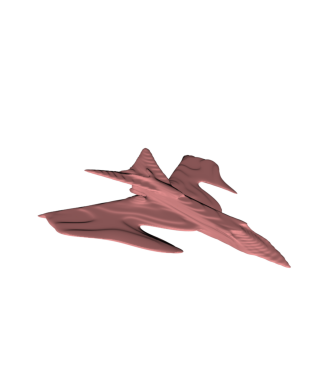

1it [00:03,  3.26s/it]

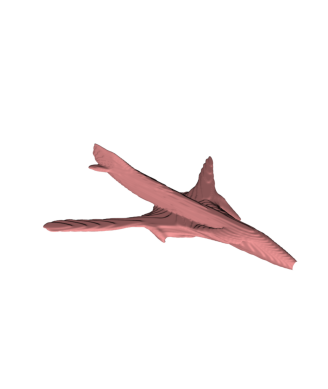

2it [00:06,  3.19s/it]

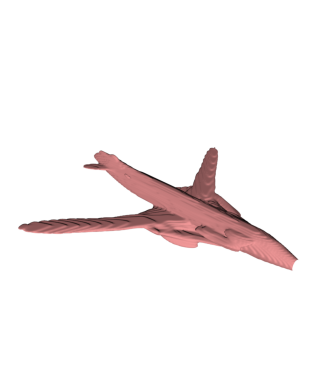

3it [00:09,  3.20s/it]

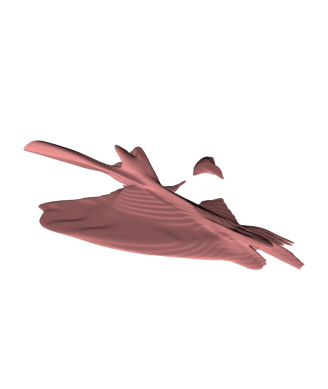

4it [00:12,  3.27s/it]

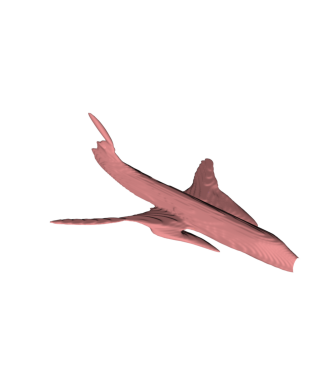

5it [00:16,  3.27s/it]

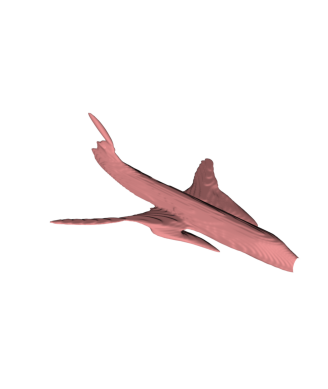

6it [00:19,  3.25s/it]


In [15]:
from tqdm import tqdm
import glob
from utils.hd_utils import render_image
files = glob.glob("./models/generation/gen*.pt")

for i, file in tqdm(enumerate(files)):
  generated_tokens = torch.load(file)

  model_dict = token_transform.inverse(generated_tokens.unsqueeze(-1))
  model_quantized = model_transform(model_dict)[0]
  #model = dataset_model[index][0]
  mesh, sdf = model_to_mesh(model_quantized, res=256)
  render_image(mesh, path=f"./models/rendering/{i}.png")

In [ ]:
tokens = pred.argmax(dim=-1).unsqueeze(-1)

model_dict = token_transform.inverse(tokens)
model_quantized = model_transform(model_dict)[0]
#model = dataset_model[index][0]
mesh, sdf = model_to_mesh(model_quantized, res=256)
mesh.show()

In [ ]:
from utils.hd_utils import render_mesh


color, depth = render_mesh(mesh)
# show color as image
plt.imshow(color)

tensor(165, device='cuda:0')

AttributeError: 'dict' object has no attribute 'shape'

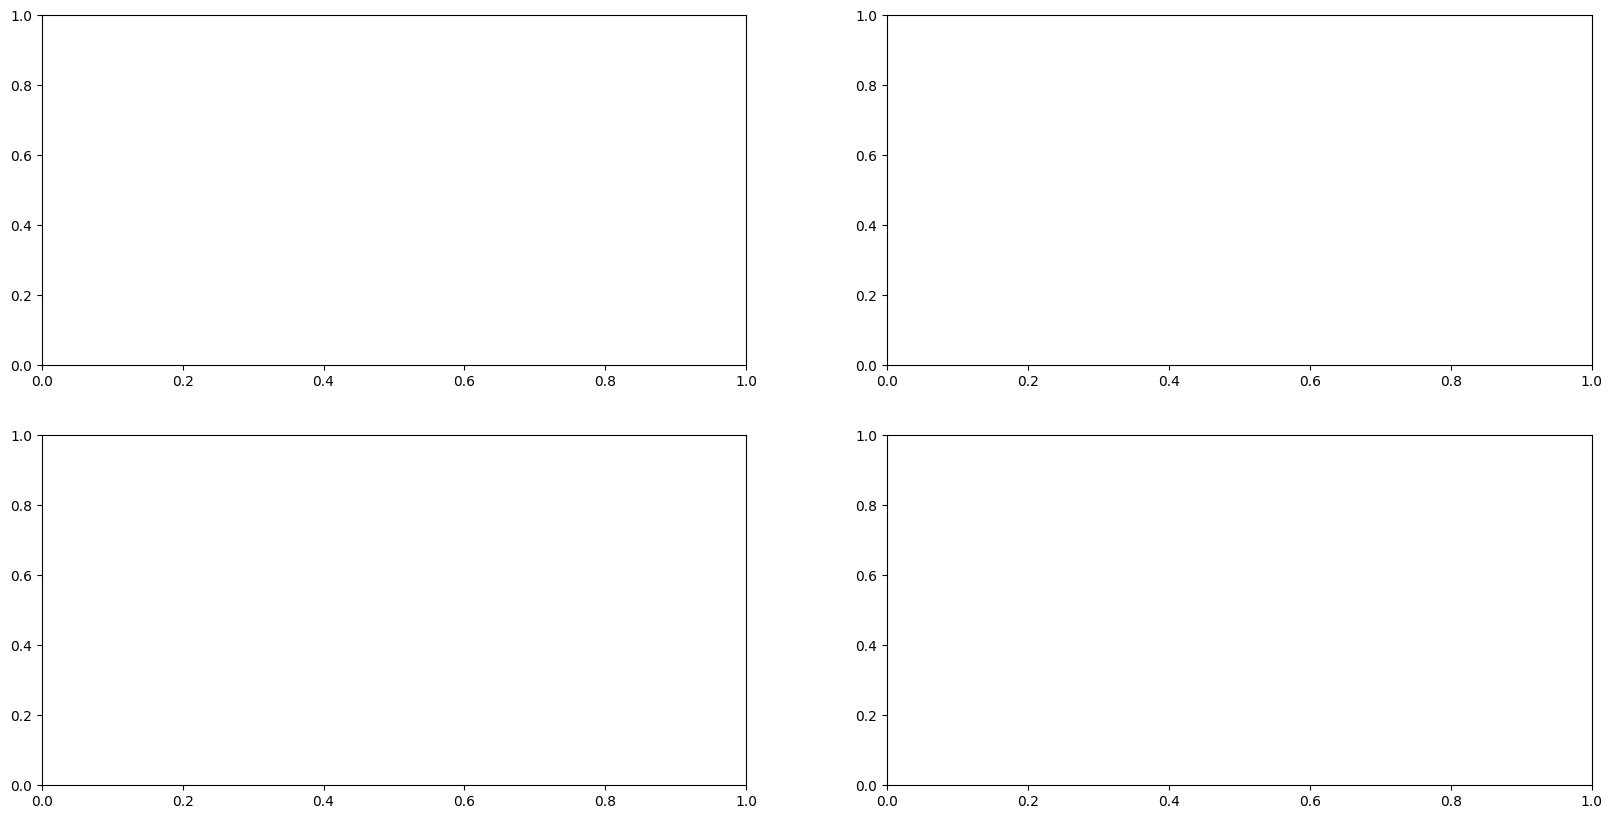

In [ ]:
from animation.util import backtransform_weights, reconstruct_image
from networks.mlp_models import MLP3D

ij_len = 2
# Plotting the tensors as heatmaps in grayscale
fig, axes = plt.subplots(ij_len, ij_len, figsize=(20, 10))


kwargs = {
"type": "pretrained",
"fixed_label": None,
}

for i in range(ij_len):
    for j in range(ij_len):

        model.eval()
        novel_tokens = model.generate(torch.Tensor([[token_dict["SOS"]]]).long().to(device="cuda"), dataset[0][0].shape[0] + 1, temperature=0.8, top_k=3)[:, 1:]

        print(novel_tokens[0][0])
        novel_tokens = novel_tokens[:, 1:].unsqueeze(-1).to("cpu")
                                                                                                                         

        max_similarity = 0
        """
        for data in dataset:
            similarity = (data[0].to(device)==noxmarty/resnet-tiny-mnist
                max_similarity = similarity
        """
        #print(f"Maximum Similarity of picture (i, j) {(i, j)}: {max_similarity}")

        novel_weights= vq.get_codes_from_indices((novel_tokens))

        dataset_no_transform = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), **kwargs)
        original_dict = dataset_no_transform[0][0]

        reconstructed_dict = backtransform_weights(novel_weights, original_dict["state_dict"])

        mlp3d = MLP3D(**original_dict["model_config"])
        mlp3d.load_state_dict(reconstructed_dict)
        reconstructed_tensor = reconstruct_image(mlp3d)

        axes[i][j].imshow(reconstructed_tensor, cmap='gray', aspect='auto')

plt.show()

In [ ]:
from training.mnist_classifier_score import compute_mnist_score
acc, loss= compute_mnist_score(model, vq, "cuda", token_dict)

print(acc)
print(loss)


0.703125
1.2872538566589355


In [ ]:
# get the logits of the gpt model generation
model.eval()
logits_conditioning = model.generate_logits(torch.Tensor([[token_dict["SOS"]]]).long().to(device="cuda"))

# do a whole autoregressive proccess and get the logits for the last token
novel_tokens = model.generate(torch.Tensor([[token_dict["SOS"]]]).long().to(device="cuda"), dataset[0][0].shape[0] + 1, temperature=0.8, top_k=3)[:, :]
logits_last = model.generate_logits(novel_tokens[:, :-1])

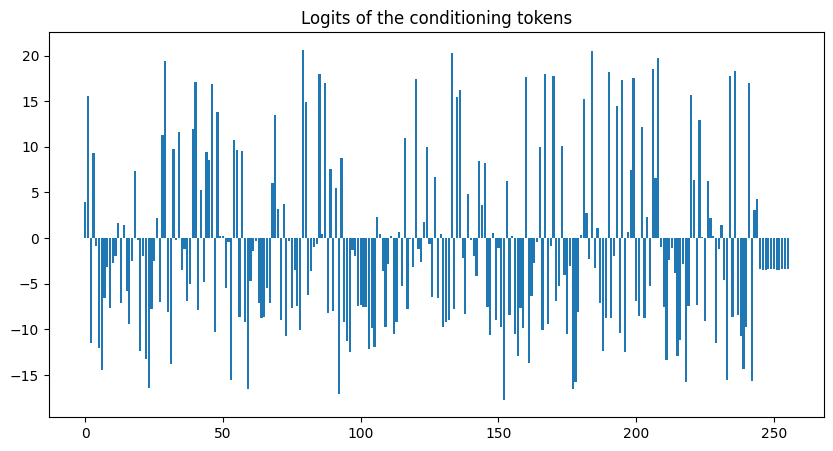

In [ ]:
# barchart of the logits
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(range(logits_last.shape[-1]), logits_last[0].detach().cpu().numpy())
ax.set_title("Logits of the conditioning tokens")
plt.show()

In [ ]:
logits

In [ ]:
# store the logits as numpy file
import numpy as np
np.save("logits_conditioning.npy", logits_conditioning.squeeze(0).detach().cpu().numpy())
np.save("logits_last.npy", logits_last.squeeze(0).detach().cpu().numpy())

Text(0.5, 1.0, 'Softmax of the logits of the conditioning tokens')

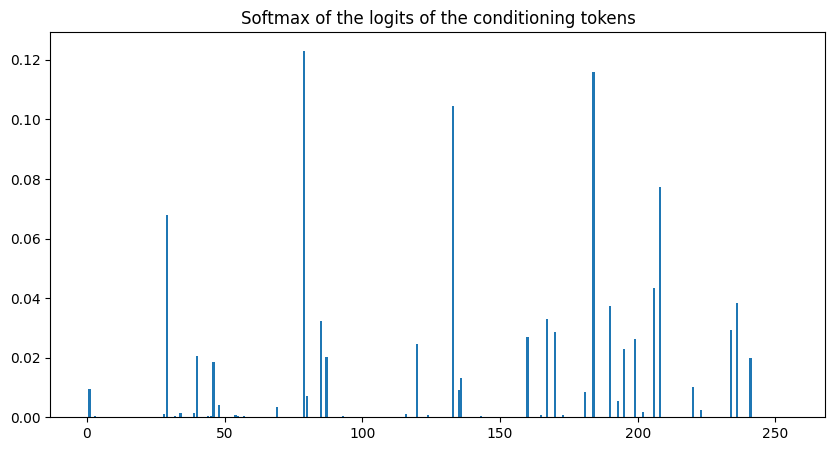

In [ ]:
# softmax of the logits conditioning
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
temperature = 2
logits = logits_last / temperature
ax.bar(range(logits_last.shape[-1]), torch.softmax(logits[0], dim=-1).detach().cpu().numpy())
ax.set_title("Softmax of the logits of the conditioning tokens")

In [ ]:
import optimize_metrics

optimize_metrics.main()

number of parameters: 5.62M
{'1': {'1': {'acc': 0.65625, 'loss': 1.4447228908538818}}}


{'1': {'1': {'acc': 0.65625, 'loss': 1.4447228908538818}}}